<a href="https://colab.research.google.com/github/acumenmanish/ImageRestoration/blob/manish/RestoreImage_using_conv_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, glob
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import PIL

In [4]:
from keras.utils import img_to_array, load_img

In [5]:
def process_image(file_path):
    try:
        with PIL.Image.open(file_path).convert('RGB') as img:
            img = img.resize((128, 128))
            return np.array(img, dtype="float32") / 255.0
    except:
        pass


In [6]:
def load_images():
  image_dir = '/content/drive/MyDrive/Input Data/images/'
  image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
  print(len(image_files))
  img = map(process_image, image_files)
  return list(img)

In [7]:
img_arr = np.array(load_images())

6241


In [8]:
img_arr.shape

(6241, 128, 128, 3)

In [9]:
# image_dir = '/content/drive/MyDrive/Input Data/images/'
# image_files = glob.glob(f"{image_dir}*.jpg")
# # Sort list of files in directory by size 
# img_var = sorted( image_files,key =  lambda x: os.stat(x).st_size,reverse=True )

# # checking the variation in the image datasets
# max_hieght, max_width, _ = np.array(PIL.Image.open(img_var[0])).shape
# min_hieght, min_width, _ = np.array(PIL.Image.open(img_var[-1])).shape
# print(max_hieght, max_width, min_hieght, min_width)



In [10]:
# #Randomly checking max and min pixel variations among image datasets
# for i in image_files[5100:5110]: 
#   img_array = np.array(PIL.Image.open(image_files[0]))
#   print(f"max_pixel value:{np.min(img_array)}")
#   print(f"max_pixel value:{np.max(img_array)}")

In [11]:
# features = []
# for i in image_files:
#   try:
#       img = PIL.Image.open(i)
#       img = img.resize((100,100))
#       if np.array(img).size ==30000:
#         features.append(np.array(img).astype("float")/255.0)
        
#   except:
#       pass

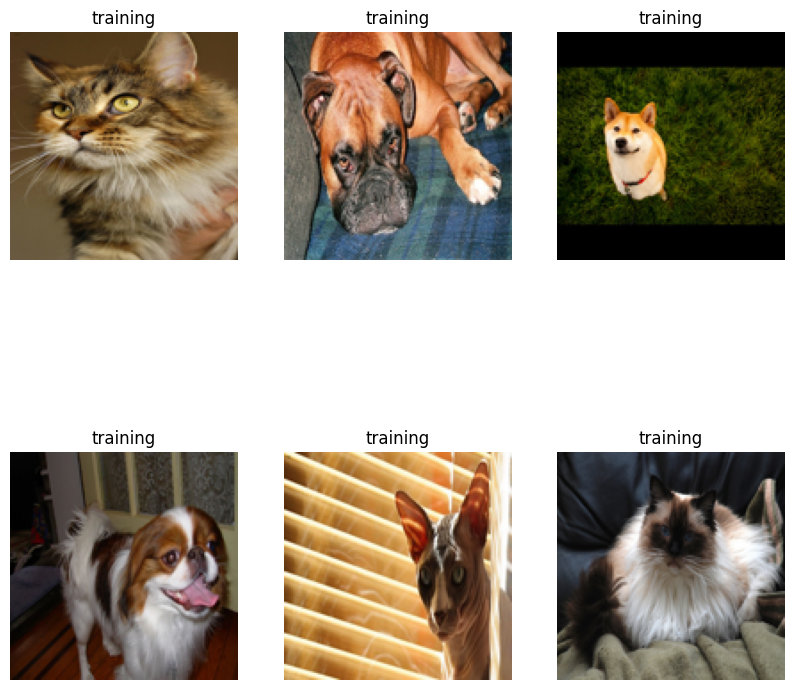

In [12]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(img_arr[i])
    plt.title('training')
    plt.axis("off")

In [13]:
image_array = np.array(img_arr)
# image_array

In [14]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(image_array, test_size=0.2, random_state=40)

In [15]:
train_data.shape, test_data.shape

((4992, 128, 128, 3), (1249, 128, 128, 3))

In [16]:
# adding noise to the training images 
noise_factor = 0.2
X_train_noisy = train_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_data.shape)  
X_train_noisy = np.clip(X_train_noisy, 0., 1.)

In [17]:
# adding noise to the training images 
noise_factor = 0.2
X_test_noisy = test_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)  
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

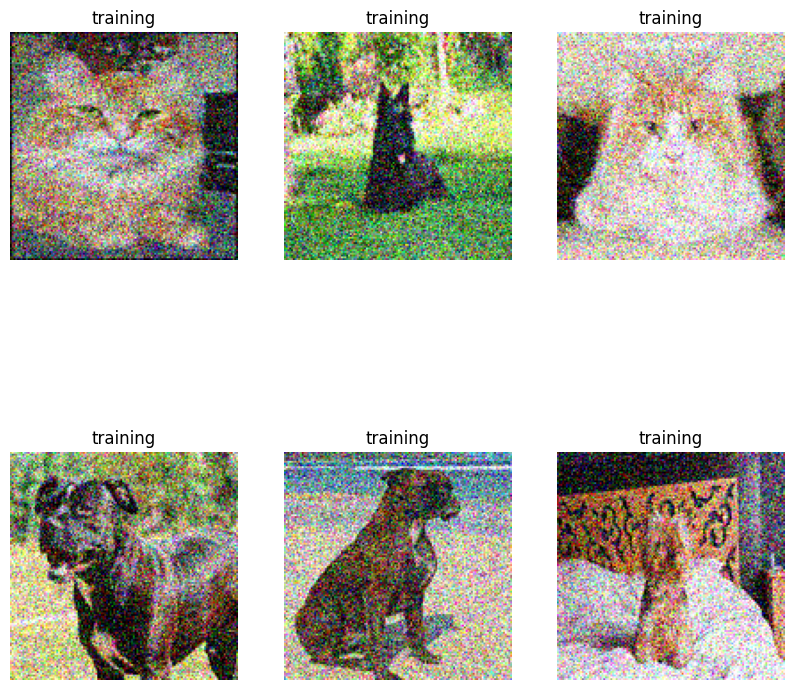

In [18]:
plt.figure(figsize=(10, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(X_train_noisy[i])
    plt.title('training')
    plt.axis("off")

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import os
import PIL


class ConvAutoencoder:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.encoder = None
        self.decoder = None
        self.autoencoder = None


    def build_encoder(self):
        input_img = keras.Input(shape=self.input_shape)

        # Encoder Layers
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        # x = layers.add(Dropout(0.25))(x) # adding a dropout layer after the max pooling layer
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

        self.encoder = keras.Model(input_img, encoded)
        self.encoder.summary()
        return encoded.shape[1:]

    def build_decoder(self, inputShape):
        # Decoder Layers
        encoded_input = keras.Input(shape=inputShape)
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_input)
        x = layers.BatchNormalization()(x)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling2D((2, 2))(x)
        decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

        self.decoder = keras.Model(encoded_input, decoded)
        self.decoder.summary()

    def build_autoencoder(self):
        input_img = keras.Input(shape=self.input_shape)
        encoded = self.encoder(input_img)
        decoded = self.decoder(encoded)
        self.autoencoder = keras.Model(input_img, decoded)
        self.autoencoder.summary()

        self.autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    def train(self, x_train, x_test, epochs, batch_size,callbacks):
        return self.autoencoder.fit(X_train_noisy,train_data,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=True,
                             callbacks=callbacks,
                             validation_data=(X_test_noisy, test_data))

    def restore(self, x):
        restored_imgs = self.autoencoder.predict(x)
        return restored_imgs




In [20]:

# Initialize the Convolutional Autoencoder
autoencoder = ConvAutoencoder(input_shape=train_data.shape[1:])

# Build the encoder, decoder and autoencoder
outputShape = autoencoder.build_encoder()
autoencoder.build_decoder(outputShape)
autoencoder.build_autoencoder()


    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128   

Model Training

In [ ]:
# Train the autoencoder on the training
# Train the model
from keras.callbacks import ModelCheckpoint
print('-------Training Starts ---------')
checkpoint = ModelCheckpoint("ImageRestore Model.h5", save_best_only=True, save_weights_only=False, verbose=1 )
autoencoder.train(X_train_noisy, train_data,  epochs=30, batch_size=64, callbacks=checkpoint )



-------Training Starts ---------
Epoch 1/30
78/78 [==============================] - ETA: 0s - loss: 0.5830

In [ ]:

# Use the trained model to restore images
# testimg = glob.glob('/content/drive/MyDrive/Input Data/*.jpg')
restored_imgs = autoencoder.restore(test_data)

In [ ]:
# Display some sample results
import matplotlib.pyplot as plt
n = 10  # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i+1200])
    plt.title("Original")
 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display restored images
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(restored_imgs[i+1200])
    plt.title("Restored")

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)     
plt.show()

In [ ]:
# loss = autoencoder.train.history['loss']
# val_loss = autoencoder.train.history['val_loss']
# epochs = range(epochs)
# plt.figure()
# plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()
# plt.show()